In [1]:
# 필요한 라이브러리 임포트
import torch
import torchvision
from PIL import Image
from pathlib import Path
from src.models import PretrainedUNet
from src.data import n_clahe  # n_clahe 함수 임포트
from torchvision import transforms, models
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# 폐 세그멘테이션 모델 설정
seg_model = PretrainedUNet(
    in_channels=1,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)

/opt/anaconda3/envs/yolo/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/yolo/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# GPU 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
models_folder = Path("models")
model_name = "unet-6v.pt"
seg_model.load_state_dict(torch.load(models_folder / model_name, map_location=device))
seg_model.to(device)
seg_model.eval()

PretrainedUNet(
  (init_conv): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): Block(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchN

In [5]:
# 이미지 후처리 함수
def postprocess_mask(mask):
    # OpenCV로 마스크 후처리
    mask = (mask * 255).astype(np.uint8)
    _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # 큰 윤곽선 두 개만 남기기
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 큰 두 개의 윤곽선만 남기기
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    new_mask = np.zeros_like(mask)
    for contour in contours:
        cv2.drawContours(new_mask, [contour], -1, 255, thickness=cv2.FILLED)

    return new_mask


In [6]:
# 이미지 처리 함수
def create_segmented_image(img_path):
    origin = Image.open(img_path).convert("L")
    origin = n_clahe(origin)  # N-CLAHE 적용
    origin_resized = torchvision.transforms.functional.resize(origin, (512, 512))
    origin_tensor = torchvision.transforms.functional.to_tensor(origin_resized) - 0.5
    
    with torch.no_grad():
        origin_tensor = torch.stack([origin_tensor]).to(device)
        out = seg_model(origin_tensor)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        mask = torch.argmax(softmax, dim=1).squeeze(0).cpu().numpy()

    # 마스크 후처리
    mask = postprocess_mask(mask)

    mask_resized = Image.fromarray((mask * 255).astype(np.uint8)).resize(origin.size, Image.NEAREST)
    segmented_img = Image.composite(origin, Image.new('L', origin.size), mask_resized)
    
    return segmented_img, mask, origin, mask_resized

In [7]:
# 진폐증 분류 모델 설정
model_pre = models.vgg16()
num_features = model_pre.classifier[6].in_features
model_pre.classifier[6] = nn.Linear(num_features, 2)  # 2 클래스: NORMAL, PNEUMONIA

In [8]:
# 학습된 모델 로드
model_pre.load_state_dict(torch.load("models/best_pneumonia_model.pth", map_location=device))
model_pre = model_pre.to(device)
model_pre.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
# 데이터 변환 함수
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [14]:
# 이미지 경로
image_path = 'input/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'

# 이미지 처리 및 추론
segmented_img, mask, origin, mask_resized = create_segmented_image(image_path)
input_tensor = data_transforms(segmented_img).unsqueeze(0).to(device)

with torch.no_grad():
    output = model_pre(input_tensor)
    _, preds = torch.max(output, 1)
    pred_class = 'PNEUMONIA' if preds.item() == 1 else 'NORMAL'

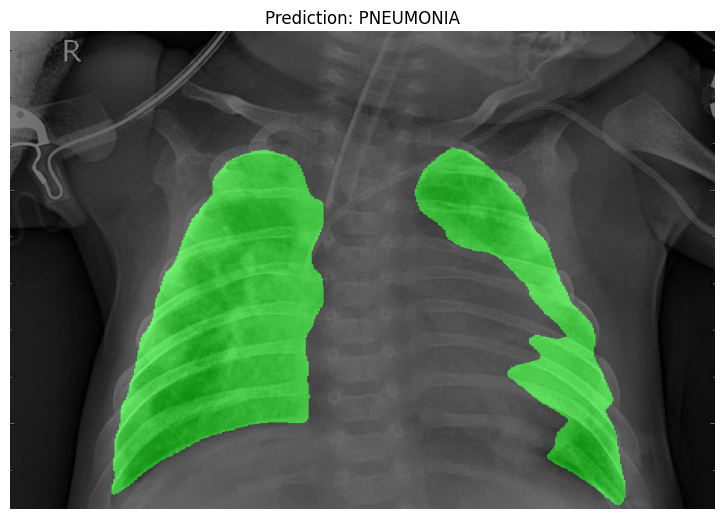

In [15]:
# 마스크를 사용하여 폐 영역만 강조
highlighted_img = np.array(origin.convert("RGB"))
mask_array = np.array(mask_resized)

# 마스크 부분을 초록색으로 설정
green_overlay = np.zeros_like(highlighted_img)
green_overlay[mask_array == 1] = [0, 255, 0]  # 255 대신 1로 변경
highlighted_img = Image.blend(Image.fromarray(highlighted_img), Image.fromarray(green_overlay), alpha=0.5)
# 시각화
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 2)
plt.title(f"Prediction: {pred_class}")
plt.imshow(highlighted_img)
plt.axis('off')

plt.show()